
# Basic Overview
The objective is to build models  using gradient tree boosting techniques on the same.

Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np

In [2]:
import sys
sys.path.append('../common_routines/')
import numpy as np
from relevant_functions import\
    fit_pipeline_and_cross_validate, \
    get_validated_transformed_data


In [3]:
import matplotlib.pyplot as plt
FIGURE_LENGTH = 16
FIGURE_BREADTH = 9


### Master plan
The main motivation behind using this technique is that the implicit regularization (in gradient boosting) would enable shrinkage of predictors, enabling us to get a tree ensemble with low dimensionality:

1. Build a gradient boosting model using all pred
2. Using the rank computed in the step above, see the cross validation score obtained , say when we include top 10 predictors, top 20 predictors etc, and hopefully arrive at an equilibrium value.

The main motivation here is that hopefully, the non parametric nature of the method, couple with our 'dimensionality control' technique can give us something interesting .Let us see !

#### First set up, set up data properly

In [4]:
complete_train_data = get_validated_transformed_data("../input/train.csv")

In [5]:
complete_train_data_one_hot = pd.get_dummies(complete_train_data)
train_data_one_hot = complete_train_data_one_hot[:(1460 - 365)].copy()
test_data_one_hot = complete_train_data_one_hot[(1460 - 365):].copy()

#### Set up pipelines appropriately

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
import xgboost as xgb
def get_xgboost_pipeline():
    my_pipe = Pipeline([('missing', Imputer(strategy='mean')),
                        ('model', XGBRegressor())
                        ])
    return my_pipe

In [7]:
predictor_cols = [col for col in train_data_one_hot.columns if col not in ['SalePrice']]


In [8]:

(my_pipe, cross_validation_score) = fit_pipeline_and_cross_validate(
    get_xgboost_pipeline(), 
    train_data_one_hot, predictor_cols)
#print(predictor_cols)
print("Cross validation score is {0}".format(cross_validation_score))

Cross validation score is 0.13572037238297738


#### Checking out the model

Let us check out more details regarding the model.

In [9]:
from relevant_functions import print_model_stats_from_pipeline

In [10]:
model_obj = my_pipe.named_steps['model']

In [11]:
model_obj

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<BarContainer object of 270 artists>

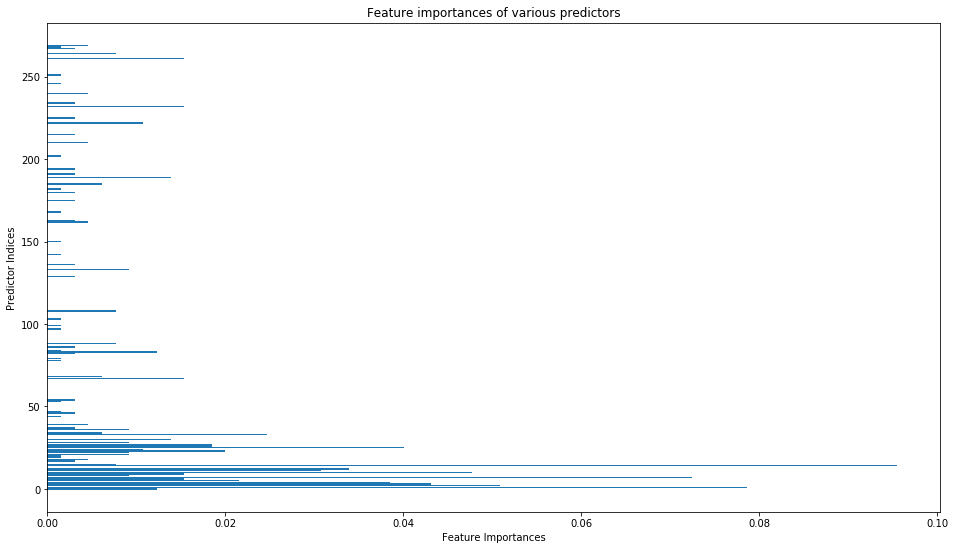

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(FIGURE_LENGTH, FIGURE_BREADTH))
ax.set_xlabel('Feature Importances')
ax.set_ylabel('Predictor Indices')
ax.set_title('Feature importances of various predictors')
ax.barh(range(len(model_obj.feature_importances_)), model_obj.feature_importances_)
#plt.show()

### Selecting predictors with importances lesser than a threshold.

Now, that we have feature importances for each predictors, we can build models by selecting all predictors with feature importances less than a threshold. For example , if threshold = 0.5, we can select predictors having feature_importance < 0.5 and build a model using the same.

In [13]:
thresholds = np.sort(model_obj.feature_importances_)

In [14]:
positive_importances = thresholds[thresholds > 0]

In [15]:
np.unique(positive_importances)

array([0.00154083, 0.00308166, 0.0046225 , 0.00616333, 0.00770416,
       0.00924499, 0.01078582, 0.01232666, 0.01386749, 0.01540832,
       0.01848998, 0.02003082, 0.02157165, 0.02465331, 0.03081664,
       0.03389831, 0.0385208 , 0.04006163, 0.0431433 , 0.0477658 ,
       0.05084746, 0.07241911, 0.07858244, 0.09553159], dtype=float32)


### Get cross validation score with a subset of predictors

In [16]:
np.nonzero(model_obj.feature_importances_)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  30,  33,  34,  36,  37,  39,  44,  46,  47,  53,  54,  67,
         68,  78,  79,  82,  83,  84,  86,  88,  97,  99, 103, 108, 129,
        133, 136, 142, 150, 162, 163, 168, 175, 180, 182, 185, 189, 191,
        194, 202, 210, 215, 222, 225, 232, 234, 240, 246, 251, 261, 264,
        267, 268, 269]),)

In [17]:
col_name_to_feature_importance = dict()
for i in np.nonzero(model_obj.feature_importances_)[0]:

    col_name = predictor_cols[i]
    feature_importance = model_obj.feature_importances_[i]
    col_name_to_feature_importance[col_name] = feature_importance

    

In [18]:
col_name_to_feature_importance_sorted = \
    [(k, col_name_to_feature_importance[k]) for k in sorted(
        col_name_to_feature_importance, key=col_name_to_feature_importance.get, reverse=True)]

In [19]:
from collections import OrderedDict
from operator import itemgetter
col_name_to_feature_importance_sorted = OrderedDict(sorted(col_name_to_feature_importance.items(), key = itemgetter(1), reverse = True))


In [20]:
columns_sorted = list(col_name_to_feature_importance_sorted.keys())
columns_sorted[0:1]


['GrLivArea']

In [21]:
columns_sorted

['GrLivArea',
 'LotArea',
 'BsmtFinSF1',
 'OverallQual',
 'TotalBsmtSF',
 'OverallCond',
 'GarageArea',
 'YearBuilt',
 '2ndFlrSF',
 '1stFlrSF',
 'MoSold',
 'YearRemodAdd',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'MasVnrArea',
 'BsmtUnfSF',
 'Neighborhood_Crawfor',
 'Functional_Typ',
 'SaleType_New',
 'ScreenPorch',
 'BsmtExposure_Gd',
 'MSSubClass',
 'Neighborhood_StoneBr',
 'GarageCars',
 'KitchenQual_Ex',
 'BsmtFinSF2',
 'TotRmsAbvGrd',
 'Fireplaces',
 'EnclosedPorch',
 'MSZoning_C (all)',
 'Exterior1st_BrkFace',
 'BsmtFullBath',
 'Condition1_Norm',
 'HouseStyle_1.5Fin',
 'SaleCondition_Abnorml',
 'YrSold',
 'Neighborhood_Edwards',
 'BsmtCond_Gd',
 'HalfBath',
 'MSZoning_RL',
 'MasVnrType_BrkFace',
 'HeatingQC_Ex',
 'GarageFinish_RFn',
 'SaleCondition_Partial',
 'FullBath',
 'MSZoning_FV',
 'LotShape_Reg',
 'LotConfig_CulDSac',
 'Neighborhood_Somerst',
 'Condition1_Artery',
 'RoofMatl_WdShngl',
 'Exterior1st_HdBoard',
 'MasVnrType_None',
 'Foundation_CBlock',
 'BsmtQual_Ex',


In [22]:
def get_cross_val_score_with_best_predictors(num_predictors_to_include=5,
                                             predictor_index_cross_val_score_df=columns_sorted,
                                             train_data_one_hot=train_data_one_hot):
    rel_cols = predictor_index_cross_val_score_df[0:num_predictors_to_include]
    (my_pipe, cross_validation_score) = fit_pipeline_and_cross_validate(
        get_xgboost_pipeline(), 
        train_data_one_hot, rel_cols)
    return cross_validation_score 

In [23]:
def get_relevant_df(index_name='predictor_index', 
                    compute_func=get_cross_val_score_with_best_predictors,
                    index_start=1,
                    predictor_cols=columns_sorted):
    NUM_POINTS = len(predictor_cols)
    predictor_index_cross_val_score_df = pd.DataFrame(np.arange(index_start,NUM_POINTS + index_start), columns=[index_name])
    predictor_index_cross_val_score_df['cross_val_score'] = \
        predictor_index_cross_val_score_df[index_name].apply(lambda x : compute_func(x))
    predictor_index_cross_val_score_df.index = predictor_index_cross_val_score_df[index_name]
    predictor_index_cross_val_score_df.drop(columns=[index_name], inplace=True)
    return predictor_index_cross_val_score_df

In [24]:
predictor_index_cross_val_score_df = get_relevant_df()

In [25]:
def plot_relevant_df(predictor_index_cross_val_score_df, 
                    title='Cross Validation score vs Predictor column index',
                    fig_length=FIGURE_LENGTH,
                    fig_breadth=FIGURE_BREADTH):
    fig, ax = plt.subplots(1, 1, figsize=(fig_length, fig_breadth))
    predictor_index_cross_val_score_df.plot(ax=ax)
    ax.set_title(title)    

In [26]:
predictor_index_cross_val_score_df

,cross_val_score
predictor_index,
1,0.280811
2,0.269021
3,0.240783
4,0.171858
5,0.169857
6,0.162849
7,0.157602
8,0.144465
9,0.146058


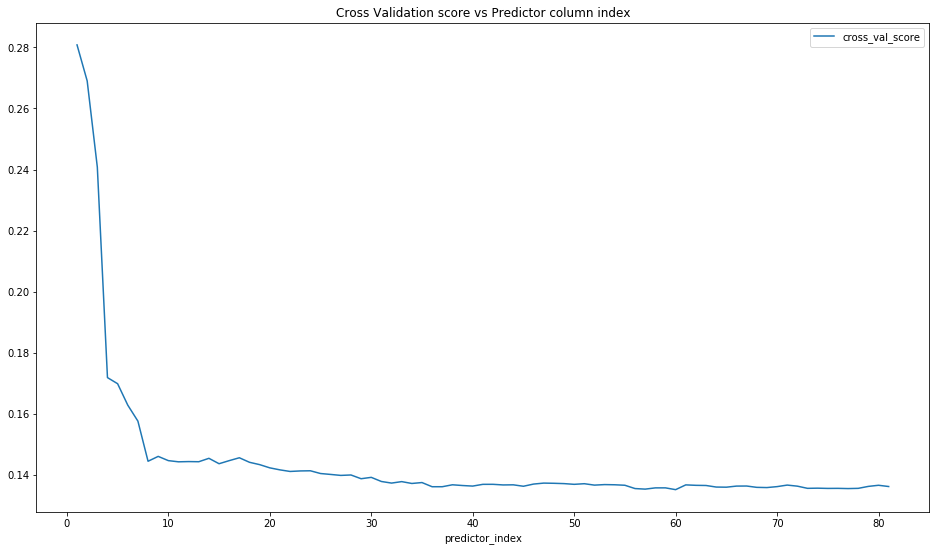

In [27]:
plot_relevant_df(predictor_index_cross_val_score_df) 

In [28]:
NUM_IMPORTANT_PREDICTORS = np.sum(model_obj.feature_importances_ > 0)
for i in range(1, NUM_IMPORTANT_PREDICTORS + 1):
    predictors_list = columns_sorted[0:i]
    (my_pipe, cross_validation_score) = fit_pipeline_and_cross_validate(
        get_xgboost_pipeline(), 
        train_data_one_hot, predictors_list)
    print(i, cross_validation_score)
    

1 0.28081065005053446
2 0.26902128298505973
3 0.2407831833170806
4 0.1718579894475329
5 0.16985674665497966
6 0.16284938229356036
7 0.1576024400894897
8 0.1444654029826691
9 0.14605833251556494
10 0.1446702105818901
11 0.14428223829554682
12 0.14435840219192736
13 0.1443099988835566
14 0.14542687280526725
15 0.14365736635903736
16 0.14466679145922562
17 0.14560842897359497
18 0.14412250282889855
19 0.14336004044665715
20 0.142304379309468
21 0.14164297709707716
22 0.14112461834101592
23 0.14129261366786944
24 0.14134644713024158
25 0.14044821521623238
26 0.14014865758417297
27 0.13983096449232318
28 0.13997092568760974
29 0.13874511037634246
30 0.1391908393966386
31 0.137839769251354
32 0.1373156450989415
33 0.137795798435381
34 0.13719145240448535
35 0.13748898516485927
36 0.1361219283940706
37 0.13612525386649243
38 0.136757259797801
39 0.13651748152622684
40 0.13633391412197648
41 0.13690516683201756
42 0.13690998840188778
43 0.13670767530784866
44 0.13674705935334264
45 0.136279176